# Learning to Rank utilizando gradient boosting

**Gradient boosting** combina modelos débiles para crear un modelo fuerte mediante la corrección iterativa de los errores de los modelos anteriores.

En este notebook utilizaremos `LightGBM` desarrollado por Microsoft, una biblioteca que implementa gradient boosting vía árboles de decisión.

Utilizaremos un dataset de series de anime para implementar un rankeo.

**Learning to rank (LTR)** es un subcampo de ML aplicable a problemas relacionados con la predicción de rankings o la recomendación de candidatos.

A diferencia de los datos de los search engines, en este caso no tenemos pares `(query, documents) `.

Trataremos a los usuarios como consultas y a los animes en los que están interesados como documentos:` (usuario, animes)`.

## Librerías

In [100]:
!pip3 install shap
!pip3 install lightgbm

In [ ]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from lightgbm import LGBMRanker

## Construcción de datasets y análisis exploratorio

Utilizaremos el siguiente dataset: https://www.kaggle.com/datasets/ransakaravihara/anime-recommendation-ltr-dataset

In [102]:
anime_info = pd.read_csv('anime_info.csv')
relevance_scores = pd.read_csv('relavence_scores.csv')
user_info = pd.read_csv('user_info.csv')

In [103]:
# Para evitar el error:
# LightGBMError: Number of rows 14203 exceeds upper limit of 10000 for a query

relevance_scores = relevance_scores[~(relevance_scores['user_id']==11100)]

In [104]:
# Cada usuario asigna una relevancia de 0 a 1 a cada anime
relevance_scores

,anime_id,Name,user_id,relavence_score
0,1,Cowboy Bebop,3,1.000000
1,1,Cowboy Bebop,6,1.000000
2,1,Cowboy Bebop,8,0.230769
3,1,Cowboy Bebop,13,0.000000
4,1,Cowboy Bebop,14,0.500000
...,...,...,...,...
4878994,48456,SK∞: Crazy Rock Jam,11897,1.000000
4878995,48456,SK∞: Crazy Rock Jam,11977,0.000000
4878996,48456,SK∞: Crazy Rock Jam,14441,0.000000
4878997,48456,SK∞: Crazy Rock Jam,15597,1.000000


In [105]:
relevance_scores.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4864759 entries, 0 to 4878998
Data columns (total 4 columns):
 #   Column           Dtype  
---  ------           -----  
 0   anime_id         int64  
 1   Name             object 
 2   user_id          int64  
 3   relavence_score  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 185.6+ MB


In [106]:
# Dataset con los usuarios
user_info

,user_id,review_count,avg_score,score_stddev,above_five_star_count,above_five_star_ratio
0,3,357,6.801120,2.475089,318.0,0.890756
1,6,545,4.089908,3.731472,285.0,0.522936
2,8,165,0.866667,2.448328,NaN,NaN
3,13,65,3.338462,4.191796,NaN,NaN
4,14,146,4.965753,3.844233,89.0,0.609589
...,...,...,...,...,...,...
15158,11765,1,0.000000,NaN,NaN,NaN
15159,16208,1,8.000000,NaN,1.0,1.000000
15160,15031,1,0.000000,NaN,NaN,NaN
15161,2680,1,0.000000,NaN,NaN,NaN


In [107]:
user_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15163 entries, 0 to 15162
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                15163 non-null  int64  
 1   review_count           15163 non-null  int64  
 2   avg_score              15163 non-null  float64
 3   score_stddev           15023 non-null  float64
 4   above_five_star_count  8631 non-null   float64
 5   above_five_star_ratio  8631 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 710.9 KB


In [108]:
# Dataset con los animes
anime_info

,anime_id,Genres,is_tv,year_aired,is_adult,above_five_star_users,above_five_star_ratings,above_five_star_ratio
0,1,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",1,1998.0,1,4012.0,4012.0,0.594018
1,5,"Action, Drama, Mystery, Sci-Fi, Space",0,2001.0,1,NaN,NaN,NaN
2,6,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",1,1998.0,0,NaN,NaN,NaN
3,7,"Action, Mystery, Police, Supernatural, Drama, ...",1,2002.0,0,NaN,NaN,NaN
4,8,"Adventure, Fantasy, Shounen, Supernatural",1,2004.0,0,76.0,76.0,0.481013
...,...,...,...,...,...,...,...,...
16676,48409,"Comedy, Parody",0,2021.0,0,NaN,NaN,NaN
16677,48411,"Sci-Fi, Slice of Life, Fantasy, Shounen",0,NaN,0,NaN,NaN,NaN
16678,48426,"Comedy, Demons, Supernatural, Shounen",0,NaN,0,NaN,NaN,NaN
16679,48438,"Slice of Life, Magic, Fantasy, Shounen",0,2021.0,0,NaN,NaN,NaN


In [109]:
anime_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16681 entries, 0 to 16680
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   anime_id                 16681 non-null  int64  
 1   Genres                   16627 non-null  object 
 2   is_tv                    16681 non-null  int64  
 3   year_aired               16558 non-null  float64
 4   is_adult                 16681 non-null  int64  
 5   above_five_star_users    5669 non-null   float64
 6   above_five_star_ratings  5669 non-null   float64
 7   above_five_star_ratio    5669 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 1.0+ MB


In [110]:
# Extraemos los géneros
genres = anime_info['Genres'].str.split(', ')

genre_counts = genres.explode().value_counts()

sorted_genres = genre_counts.sort_values(ascending=False)

# Top k géneros
k = 10
top_k_genres = sorted_genres.head(k)

print(top_k_genres)

Genres
Comedy       5811
Action       3755
Fantasy      3095
Adventure    2864
Sci-Fi       2518
Drama        2473
Kids         2335
Music        2182
Shounen      1954
Romance      1843
Name: count, dtype: int64


In [111]:
popular_genres = top_k_genres.index.tolist()
print(popular_genres)

['Comedy', 'Action', 'Fantasy', 'Adventure', 'Sci-Fi', 'Drama', 'Kids', 'Music', 'Shounen', 'Romance']


In [112]:
def create_genre_flags(df, popular_genres):
    df = df.dropna(subset=['Genres'])
    df['Genres'] = df['Genres'].apply(lambda x:",".join(s.strip() for s in x.split(",")))

    # Use MultiLabelBinarizer to create a one-hot encoded dataframe of the genres
    mlb = MultiLabelBinarizer()
    genre_df = pd.DataFrame(mlb.fit_transform(df['Genres'].str.split(',')),
                            columns=mlb.classes_,
                            index=df.index)

    # Create a new dataframe with the movie id and genre columns
    new_df = pd.concat([df['anime_id'], genre_df[popular_genres]], axis=1)
    new_df.columns = ['anime_id'] + popular_genres

    return new_df

In [113]:
anime_genres = create_genre_flags(anime_info, popular_genres)

<ipython-input-112-026a9d4beb79>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Genres'] = df['Genres'].apply(lambda x:",".join(s.strip() for s in x.split(",")))


In [114]:
anime_genres

,anime_id,Comedy,Action,Fantasy,Adventure,Sci-Fi,Drama,Kids,Music,Shounen,Romance
0,1,1,1,0,1,1,1,0,0,0,0
1,5,0,1,0,0,1,1,0,0,0,0
2,6,1,1,0,1,1,1,0,0,1,0
3,7,0,1,0,0,0,1,0,0,0,0
4,8,0,0,1,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
16676,48409,1,0,0,0,0,0,0,0,0,0
16677,48411,0,0,1,0,1,0,0,0,1,0
16678,48426,1,0,0,0,0,0,0,0,1,0
16679,48438,0,0,1,0,0,0,0,0,1,0


In [115]:
anime_genres.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16627 entries, 0 to 16680
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   anime_id   16627 non-null  int64
 1   Comedy     16627 non-null  int64
 2   Action     16627 non-null  int64
 3   Fantasy    16627 non-null  int64
 4   Adventure  16627 non-null  int64
 5   Sci-Fi     16627 non-null  int64
 6   Drama      16627 non-null  int64
 7   Kids       16627 non-null  int64
 8   Music      16627 non-null  int64
 9   Shounen    16627 non-null  int64
 10  Romance    16627 non-null  int64
dtypes: int64(11)
memory usage: 1.5 MB


In [116]:
anime_info_final = anime_info.merge(anime_genres, on='anime_id')

In [117]:
del anime_info_final['Genres']

In [118]:
anime_info_final

,anime_id,is_tv,year_aired,is_adult,above_five_star_users,above_five_star_ratings,above_five_star_ratio,Comedy,Action,Fantasy,Adventure,Sci-Fi,Drama,Kids,Music,Shounen,Romance
0,1,1,1998.0,1,4012.0,4012.0,0.594018,1,1,0,1,1,1,0,0,0,0
1,5,0,2001.0,1,NaN,NaN,NaN,0,1,0,0,1,1,0,0,0,0
2,6,1,1998.0,0,NaN,NaN,NaN,1,1,0,1,1,1,0,0,1,0
3,7,1,2002.0,0,NaN,NaN,NaN,0,1,0,0,0,1,0,0,0,0
4,8,1,2004.0,0,76.0,76.0,0.481013,0,0,1,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16622,48409,0,2021.0,0,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0
16623,48411,0,NaN,0,NaN,NaN,NaN,0,0,1,0,1,0,0,0,1,0
16624,48426,0,NaN,0,NaN,NaN,NaN,1,0,0,0,0,0,0,0,1,0
16625,48438,0,2021.0,0,NaN,NaN,NaN,0,0,1,0,0,0,0,0,1,0


In [119]:
anime_info_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16627 entries, 0 to 16626
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   anime_id                 16627 non-null  int64  
 1   is_tv                    16627 non-null  int64  
 2   year_aired               16505 non-null  float64
 3   is_adult                 16627 non-null  int64  
 4   above_five_star_users    5655 non-null   float64
 5   above_five_star_ratings  5655 non-null   float64
 6   above_five_star_ratio    5655 non-null   float64
 7   Comedy                   16627 non-null  int64  
 8   Action                   16627 non-null  int64  
 9   Fantasy                  16627 non-null  int64  
 10  Adventure                16627 non-null  int64  
 11  Sci-Fi                   16627 non-null  int64  
 12  Drama                    16627 non-null  int64  
 13  Kids                     16627 non-null  int64  
 14  Music                 

Transformamos los textos de las columnas...

In [120]:
anime_info_final.columns = [col if col=='anime_id' else f"ANIME_FEATURE {col}".upper() for col in anime_info_final.columns]

In [121]:
anime_info_final.columns

Index(['anime_id', 'ANIME_FEATURE IS_TV', 'ANIME_FEATURE YEAR_AIRED',
       'ANIME_FEATURE IS_ADULT', 'ANIME_FEATURE ABOVE_FIVE_STAR_USERS',
       'ANIME_FEATURE ABOVE_FIVE_STAR_RATINGS',
       'ANIME_FEATURE ABOVE_FIVE_STAR_RATIO', 'ANIME_FEATURE COMEDY',
       'ANIME_FEATURE ACTION', 'ANIME_FEATURE FANTASY',
       'ANIME_FEATURE ADVENTURE', 'ANIME_FEATURE SCI-FI',
       'ANIME_FEATURE DRAMA', 'ANIME_FEATURE KIDS', 'ANIME_FEATURE MUSIC',
       'ANIME_FEATURE SHOUNEN', 'ANIME_FEATURE ROMANCE'],
      dtype='object')

In [122]:
user_info.columns = [col if col=='user_id' else f"USER_FEATURE {col}".upper() for col in user_info.columns]

In [123]:
user_info.columns

Index(['user_id', 'USER_FEATURE REVIEW_COUNT', 'USER_FEATURE AVG_SCORE',
       'USER_FEATURE SCORE_STDDEV', 'USER_FEATURE ABOVE_FIVE_STAR_COUNT',
       'USER_FEATURE ABOVE_FIVE_STAR_RATIO'],
      dtype='object')

In [124]:
train_intermedio = relevance_scores.merge(anime_info_final)
train = train_intermedio.merge(user_info, how='inner')

In [125]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4864372 entries, 0 to 4864371
Data columns (total 25 columns):
 #   Column                                 Dtype  
---  ------                                 -----  
 0   anime_id                               int64  
 1   Name                                   object 
 2   user_id                                int64  
 3   relavence_score                        float64
 4   ANIME_FEATURE IS_TV                    int64  
 5   ANIME_FEATURE YEAR_AIRED               float64
 6   ANIME_FEATURE IS_ADULT                 int64  
 7   ANIME_FEATURE ABOVE_FIVE_STAR_USERS    float64
 8   ANIME_FEATURE ABOVE_FIVE_STAR_RATINGS  float64
 9   ANIME_FEATURE ABOVE_FIVE_STAR_RATIO    float64
 10  ANIME_FEATURE COMEDY                   int64  
 11  ANIME_FEATURE ACTION                   int64  
 12  ANIME_FEATURE FANTASY                  int64  
 13  ANIME_FEATURE ADVENTURE                int64  
 14  ANIME_FEATURE SCI-FI                   int64  
 15

In [126]:
train

,anime_id,Name,user_id,relavence_score,ANIME_FEATURE IS_TV,ANIME_FEATURE YEAR_AIRED,ANIME_FEATURE IS_ADULT,ANIME_FEATURE ABOVE_FIVE_STAR_USERS,ANIME_FEATURE ABOVE_FIVE_STAR_RATINGS,ANIME_FEATURE ABOVE_FIVE_STAR_RATIO,...,ANIME_FEATURE DRAMA,ANIME_FEATURE KIDS,ANIME_FEATURE MUSIC,ANIME_FEATURE SHOUNEN,ANIME_FEATURE ROMANCE,USER_FEATURE REVIEW_COUNT,USER_FEATURE AVG_SCORE,USER_FEATURE SCORE_STDDEV,USER_FEATURE ABOVE_FIVE_STAR_COUNT,USER_FEATURE ABOVE_FIVE_STAR_RATIO
0,1,Cowboy Bebop,3,1.000000,1,1998.0,1,4012.0,4012.0,0.594018,...,1,0,0,0,0,357,6.801120,2.475089,318.0,0.890756
1,1,Cowboy Bebop,6,1.000000,1,1998.0,1,4012.0,4012.0,0.594018,...,1,0,0,0,0,545,4.089908,3.731472,285.0,0.522936
2,1,Cowboy Bebop,8,0.230769,1,1998.0,1,4012.0,4012.0,0.594018,...,1,0,0,0,0,165,0.866667,2.448328,NaN,NaN
3,1,Cowboy Bebop,13,0.000000,1,1998.0,1,4012.0,4012.0,0.594018,...,1,0,0,0,0,65,3.338462,4.191796,NaN,NaN
4,1,Cowboy Bebop,14,0.500000,1,1998.0,1,4012.0,4012.0,0.594018,...,1,0,0,0,0,146,4.965753,3.844233,89.0,0.609589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4864367,48456,SK∞: Crazy Rock Jam,11897,1.000000,0,2021.0,0,7.0,7.0,0.350000,...,0,0,0,0,0,292,5.219178,4.204388,NaN,NaN
4864368,48456,SK∞: Crazy Rock Jam,11977,0.000000,0,2021.0,0,7.0,7.0,0.350000,...,0,0,0,0,0,395,4.546835,3.522907,NaN,NaN
4864369,48456,SK∞: Crazy Rock Jam,14441,0.000000,0,2021.0,0,7.0,7.0,0.350000,...,0,0,0,0,0,996,1.257028,2.997185,NaN,NaN
4864370,48456,SK∞: Crazy Rock Jam,15597,1.000000,0,2021.0,0,7.0,7.0,0.350000,...,0,0,0,0,0,2435,0.834086,2.645361,222.0,0.091170


In [180]:
na_counts = (train.isna().sum() * 100/len(train))
na_counts

,0
anime_id,0.000000
Name,0.000000
relavence_score,0.000000
ANIME_FEATURE IS_TV,0.000000
ANIME_FEATURE YEAR_AIRED,0.082642
ANIME_FEATURE IS_ADULT,0.000000
ANIME_FEATURE ABOVE_FIVE_STAR_USERS,47.565174
ANIME_FEATURE ABOVE_FIVE_STAR_RATINGS,47.565174
ANIME_FEATURE ABOVE_FIVE_STAR_RATIO,47.565174
ANIME_FEATURE COMEDY,0.000000


In [181]:
train = train.drop(na_counts[na_counts > 0].index,axis=1)

In [182]:
train.sort_values(by='user_id',inplace=True)

In [183]:
train

,anime_id,Name,relavence_score,ANIME_FEATURE IS_TV,ANIME_FEATURE IS_ADULT,ANIME_FEATURE COMEDY,ANIME_FEATURE ACTION,ANIME_FEATURE FANTASY,ANIME_FEATURE ADVENTURE,ANIME_FEATURE SCI-FI,ANIME_FEATURE DRAMA,ANIME_FEATURE KIDS,ANIME_FEATURE MUSIC,ANIME_FEATURE SHOUNEN,ANIME_FEATURE ROMANCE,USER_FEATURE REVIEW_COUNT,USER_FEATURE AVG_SCORE
user_id,,,,,,,,,,,,,,,,,
0,4898,Kuroshitsuji,0.041667,1,1,1,1,0,0,0,0,0,0,1,0,71,4.732394
0,459,One Piece Movie 1,1.000000,0,0,1,1,1,1,0,0,0,0,1,0,71,4.732394
0,1047,On Your Mark,1.000000,0,0,0,0,0,0,1,1,0,1,0,0,71,4.732394
0,1074,Naruto Narutimate Hero 3: Tsuini Gekitotsu! Jo...,1.000000,0,0,1,0,0,1,0,0,0,0,1,0,71,4.732394
0,419,Samurai Deeper Kyou,1.000000,1,0,1,0,0,1,0,0,0,0,1,0,71,4.732394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16508,12291,Acchi Kocchi (TV),1.000000,1,0,1,0,0,0,0,0,0,0,0,1,78,6.628205
16508,16273,Acchi Kocchi (TV): Place=Princess,1.000000,0,0,1,0,0,0,0,0,0,0,0,1,78,6.628205
16508,16211,Bakumatsu Gijinden Roman,1.000000,1,0,0,0,1,0,0,0,0,0,0,0,78,6.628205


In [131]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4864372 entries, 609633 to 3486615
Data columns (total 25 columns):
 #   Column                                 Dtype  
---  ------                                 -----  
 0   anime_id                               int64  
 1   Name                                   object 
 2   user_id                                int64  
 3   relavence_score                        float64
 4   ANIME_FEATURE IS_TV                    int64  
 5   ANIME_FEATURE YEAR_AIRED               float64
 6   ANIME_FEATURE IS_ADULT                 int64  
 7   ANIME_FEATURE ABOVE_FIVE_STAR_USERS    float64
 8   ANIME_FEATURE ABOVE_FIVE_STAR_RATINGS  float64
 9   ANIME_FEATURE ABOVE_FIVE_STAR_RATIO    float64
 10  ANIME_FEATURE COMEDY                   int64  
 11  ANIME_FEATURE ACTION                   int64  
 12  ANIME_FEATURE FANTASY                  int64  
 13  ANIME_FEATURE ADVENTURE                int64  
 14  ANIME_FEATURE SCI-FI                   int64  
 15

In [132]:
train.set_index("user_id",inplace=True)

In [133]:
train

,anime_id,Name,relavence_score,ANIME_FEATURE IS_TV,ANIME_FEATURE YEAR_AIRED,ANIME_FEATURE IS_ADULT,ANIME_FEATURE ABOVE_FIVE_STAR_USERS,ANIME_FEATURE ABOVE_FIVE_STAR_RATINGS,ANIME_FEATURE ABOVE_FIVE_STAR_RATIO,ANIME_FEATURE COMEDY,...,ANIME_FEATURE DRAMA,ANIME_FEATURE KIDS,ANIME_FEATURE MUSIC,ANIME_FEATURE SHOUNEN,ANIME_FEATURE ROMANCE,USER_FEATURE REVIEW_COUNT,USER_FEATURE AVG_SCORE,USER_FEATURE SCORE_STDDEV,USER_FEATURE ABOVE_FIVE_STAR_COUNT,USER_FEATURE ABOVE_FIVE_STAR_RATIO
user_id,,,,,,,,,,,,,,,,,,,,,
0,877,Nana,0.021277,1,2006.0,0,NaN,NaN,NaN,1,...,1,0,1,0,1,71,4.732394,3.935036,NaN,NaN
0,3010,Kaiketsu Zorro,1.000000,1,1996.0,0,93.0,93.0,0.603896,0,...,0,0,0,1,0,71,4.732394,3.935036,NaN,NaN
0,1829,Ged Senki,1.000000,0,2006.0,0,735.0,735.0,0.616611,0,...,0,0,0,0,0,71,4.732394,3.935036,NaN,NaN
0,2034,Lovely★Complex,1.000000,1,2007.0,0,2264.0,2264.0,0.584711,1,...,0,0,0,0,1,71,4.732394,3.935036,NaN,NaN
0,1985,UFO Robo Grendizer,0.000000,1,1975.0,0,NaN,NaN,NaN,0,...,0,0,0,1,0,71,4.732394,3.935036,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16508,15411,Arcana Famiglia: Capriccio - stile Arcana Fami...,1.000000,0,2013.0,0,NaN,NaN,NaN,0,...,0,0,0,0,1,78,6.628205,3.195407,63.0,0.807692
16508,28755,Boruto: Naruto the Movie,1.000000,0,2015.0,0,1347.0,1347.0,0.732463,1,...,0,0,0,1,0,78,6.628205,3.195407,63.0,0.807692
16508,1686,Bleach Movie 1: Memories of Nobody,1.000000,0,2006.0,0,1763.0,1763.0,0.762214,1,...,0,0,0,1,0,78,6.628205,3.195407,63.0,0.807692


In [134]:
features = train.columns[3:]
features

Index(['ANIME_FEATURE IS_TV', 'ANIME_FEATURE YEAR_AIRED',
       'ANIME_FEATURE IS_ADULT', 'ANIME_FEATURE ABOVE_FIVE_STAR_USERS',
       'ANIME_FEATURE ABOVE_FIVE_STAR_RATINGS',
       'ANIME_FEATURE ABOVE_FIVE_STAR_RATIO', 'ANIME_FEATURE COMEDY',
       'ANIME_FEATURE ACTION', 'ANIME_FEATURE FANTASY',
       'ANIME_FEATURE ADVENTURE', 'ANIME_FEATURE SCI-FI',
       'ANIME_FEATURE DRAMA', 'ANIME_FEATURE KIDS', 'ANIME_FEATURE MUSIC',
       'ANIME_FEATURE SHOUNEN', 'ANIME_FEATURE ROMANCE',
       'USER_FEATURE REVIEW_COUNT', 'USER_FEATURE AVG_SCORE',
       'USER_FEATURE SCORE_STDDEV', 'USER_FEATURE ABOVE_FIVE_STAR_COUNT',
       'USER_FEATURE ABOVE_FIVE_STAR_RATIO'],
      dtype='object')

In [135]:
target = train.columns[2]
target

'relavence_score'

Nuestro target a predecir es relavance_score [sic].

Nuestro modelo de LightGBM aprenderá una función para clasificar animes en un orden óptimo (del más relevante al menos relevante) para un dado usuario.

## Entrenamiento

In [136]:
test_size = int(1e5) # 100,000

X, y = train[features], train[target].apply(lambda x:int(x*10))
test_idx_start = len(X) - test_size

# Hacemos un split manual de los datos
xtrain, xtest, ytrain, ytest = X.iloc[0:test_idx_start], X.iloc[test_idx_start:], y.iloc[0:test_idx_start], y.iloc[test_idx_start:]

In [137]:
get_group_size = lambda df: df.reset_index().groupby("user_id")['user_id'].count()

 La idea del parámetro de grupo es dividir el conjunto de datos para cada par `(consulta, documentos)`. Esto permite que el modelo aprenda la importancia relativa de diferentes características dentro de cada grupo.

Por ejemplo, para un dataset de 6 elementos con  grupo = [3, 2, 1]:

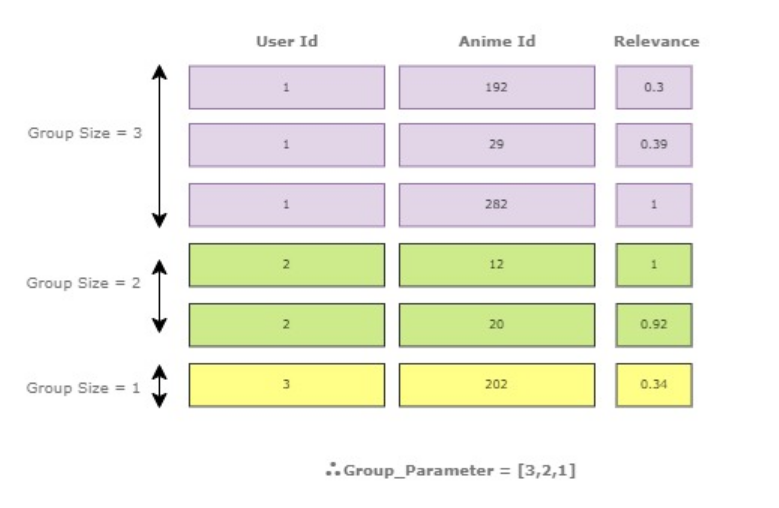

In [138]:
train_groups = get_group_size(xtrain)
test_groups = get_group_size(xtest)

In [139]:
train_groups

,user_id
user_id,
0,71
1,126
2,484
3,357
4,155
...,...
16162,60
16163,313
16165,92


In [140]:
sum(train_groups) , sum(test_groups)

(4764372, 100000)

**Entrenamiento de LightGBM**

Documentación: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRanker.html

**Función objetivo: `Lambda Rank`**

LambdaRank es una función objetivo (en lugar de un ECM o Cross-Entropy) diseñada para optimizar directamente métricas de clasificación basadas en rankings, como el NDCG (Normalized Discounted Cumulative Gain) o el MAP (Mean Average Precision), comunes en sistemas de recuperación de información y sistemas de recomendación.

LambdaRank se enfoca en optimizar la ordenación relativa de los resultados de búsqueda o recomendación, en lugar de simplemente predecir etiquetas binarias o de regresión.

**`n_estimators`**

Especifica el número de iteraciones de boosting que el modelo utilizará. Más iteraciones pueden mejorar potencialmente el rendimiento del modelo, pero también aumentan el tiempo de entrenamiento y el riesgo de sobreajuste.

In [141]:
model = LGBMRanker(objective="lambdarank", n_estimators=20)
model.fit(xtrain, ytrain,
          group=train_groups,
          eval_set=[(xtest,ytest)], eval_group=[test_groups],
          eval_metric=['map'])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total groups: 14841, total data: 4764372
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 3.229316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2126
[LightGBM] [Info] Number of data points in the train set: 4764372, number of used features: 21
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total groups: 322, total data: 100000


LGBMRanker(n_estimators=20, objective='lambdarank')

**Métrica usada:** Precisión Media Promediada (MAP)

Mide qué tan bien el modelo ordena los elementos relevantes por encima de los irrelevantes.

Para una sola consulta, se calcula el average precision o precisión promediada se calcula como:

$$
AP = \frac{1}{|R|} \sum_{k=1}^{n} P(k) \cdot rel(k)
$$

donde:

- $ R $ es el conjunto de documentos relevantes.
- $ rel(k) = 1 $ si el documento en la posición $ k $ es relevante, y 0 en caso contrario.
- $ P(k) $ es la precisión en la posición $ k $, es decir, la fracción de documentos relevantes en las primeras $ k $ posiciones.

Después, promediamos sobre todas las consultas para obtener el MAP.

## Resultados

In [145]:
user_2_anime = relevance_scores.groupby("user_id").agg({"anime_id":lambda x:list(set(x))})

In [146]:
user_2_anime

,anime_id
user_id,
0,"[256, 3457, 134, 269, 272, 19, 1047, 24, 1689,..."
1,"[3588, 39940, 22535, 31240, 35847, 35849, 2817..."
2,"[12293, 22535, 36876, 22543, 14353, 19, 36885,..."
3,"[1, 12291, 28677, 22535, 30727, 14345, 18, 616..."
4,"[2563, 1029, 1542, 16, 530, 1043, 3091, 1562, ..."
...,...
16504,"[1, 5, 6, 22535, 28677, 14345, 14349, 19, 20, ..."
16505,"[4224, 24833, 9989, 6, 22535, 136, 35848, 3034..."
16506,"[43013, 36876, 22543, 18455, 36889, 10280, 143..."


In [147]:
user_2_anime_map = dict(zip(user_2_anime.index, user_2_anime['anime_id']))

In [ ]:
# animes candidatos a ser rankeados
candidate_pool = anime_info_final['anime_id'].unique().tolist()

In [150]:
# animes candidatos a ser rankeados y no vistos por cierto usuario
def candidate_generation(user_id,candidate_pool,user_2_anime_map,N):
    already_interacted = user_2_anime_map[user_id]
    candidates = list(set(candidate_pool) - set(already_interacted))
    return already_interacted, np.random.choice(candidates,size=N)

In [155]:
anime_id_2_name = relevance_scores.drop_duplicates(subset=["anime_id","Name"])[['anime_id',"Name"]]
anime_id_2_name_map = dict(zip(anime_id_2_name['anime_id'],anime_id_2_name['Name']))
anime_id_2_name_map

{1: 'Cowboy Bebop',
 5: 'Cowboy Bebop: Tengoku no Tobira',
 6: 'Trigun',
 7: 'Witch Hunter Robin',
 8: 'Bouken Ou Beet',
 15: 'Eyeshield 21',
 16: 'Hachimitsu to Clover',
 17: 'Hungry Heart: Wild Striker',
 18: 'Initial D Fourth Stage',
 19: 'Monster',
 20: 'Naruto',
 22: 'Tennis no Ouji-sama',
 23: 'Ring ni Kakero 1',
 24: 'School Rumble',
 25: 'Sunabouzu',
 26: 'Texhnolyze',
 27: 'Trinity Blood',
 28: 'Yakitate!! Japan',
 29: 'Zipang',
 30: 'Neon Genesis Evangelion',
 31: 'Neon Genesis Evangelion: Death & Rebirth',
 32: 'Neon Genesis Evangelion: The End of Evangelion',
 33: 'Kenpuu Denki Berserk',
 43: 'Koukaku Kidoutai',
 44: 'Rurouni Kenshin: Meiji Kenkaku Romantan - Tsuioku-hen',
 45: 'Rurouni Kenshin: Meiji Kenkaku Romantan',
 46: 'Rurouni Kenshin: Meiji Kenkaku Romantan - Ishinshishi e no Chinkonka',
 47: 'Akira',
 48: '.hack//Sign',
 49: 'Aa! Megami-sama!',
 50: 'Aa! Megami-sama! (TV)',
 51: 'Tenshi Kinryouku',
 52: 'Kidou Tenshi Angelic Layer',
 53: 'Ai Yori Aoshi',
 54: 'Appl

In [156]:
def generate_predictions(user_id, user_2_anime_map, candidate_pool,
                         feature_columns, anime_id_2_name_map, ranker, N=100):

    # Generamos los animes candidatos
    already_liked, candidates = candidate_generation(user_id,candidate_pool,user_2_anime_map,N=10000)
    candidates_df = pd.DataFrame(data=pd.Series(candidates, name='anime_id'))

    # Accedemos al dataframe
    features = anime_info_final.merge(candidates_df)
    features['user_id'] = user_id
    features = features.merge(user_info)

    # Manejo de casos donde obtenemos animes no vistos por el usuario
    already_liked = list(already_liked)
    if len(already_liked) < len(candidates):
        append_list = np.full(fill_value = -1,
                              shape=(len(candidates)-len(already_liked)))
        already_liked.extend(list(append_list))

    # Generamos las predicciones
    predictions = pd.DataFrame(index=candidates)
    predictions['name'] = np.array([anime_id_2_name_map.get(id_) for id_ in candidates])

    predictions['score'] = ranker.predict(features[feature_columns])

    predictions = predictions.sort_values(by='score',ascending=False).head(N)
    predictions[f'already_liked'] = [anime_id_2_name_map.get(id_) for id_ in already_liked[0:len(predictions)]]

    return predictions

In [187]:
# ingrese aquí el id del usuario a rankear sus animes
user_id = 5
generate_predictions(user_id, user_2_anime_map, candidate_pool, feature_columns=features, anime_id_2_name_map=anime_id_2_name_map, ranker=model, N=10)

,name,score,already_liked
34927,Rilu Rilu Fairilu: Mahou no Kagami,2.107500,Tenkuu no Shiro Laputa
3685,4-Day Weekend,2.107500,School Rumble: Ichi Gakki Hoshuu
10459,Puu-Neko,2.107500,Back Street Girls: Gokudolls
6895,Hakuouki,2.043940,Shokugeki no Souma
39314,Deep Blue Song,2.043940,Hachimitsu to Clover
12343,Dirty Pair Flash 2,2.000033,Bishoujo Senshi Sailor Moon
25063,None,2.000033,Bishoujo Senshi Sailor Moon R: The Movie
17747,Furyou ni Hamerarete Jusei Suru Kyonyuu Okaasa...,2.000033,Bishoujo Senshi Sailor Moon S
33174,None,2.000033,Karakai Jouzu no Takagi-san
42320,Liu Yi Chuanqi,2.000033,Slayers


**Explicando el modelo vía valores de Shapley**

In [178]:
def generate_shap_plots(ranker, X_train, feature_names, N=3):
    """
    Generates SHAP plots for a pre-trained LightGBM model.

    Parameters:
        ranker (lightgbm.Booster): A trained LightGBM model
        X_train (np.ndarray): The training data used to fit the model
        feature_names (List): list of feature names
        N (int): The number of plots to generate

    Returns:
        None
    """
    explainer = shap.Explainer(ranker, X_train, feature_names=feature_names)
    shap_values = explainer(X_train.iloc[:N])

    # Plot the summary plot on the first subplot
    plt.subplot(1, 2, 1)
    shap.summary_plot(shap_values, feature_names=feature_names, plot_type='bar')

    # Plot the feature importance plot on the second subplot
    plt.subplot(1, 2, 2)
    shap.summary_plot(shap_values, feature_names=feature_names, plot_type='dot')

    plt.show()

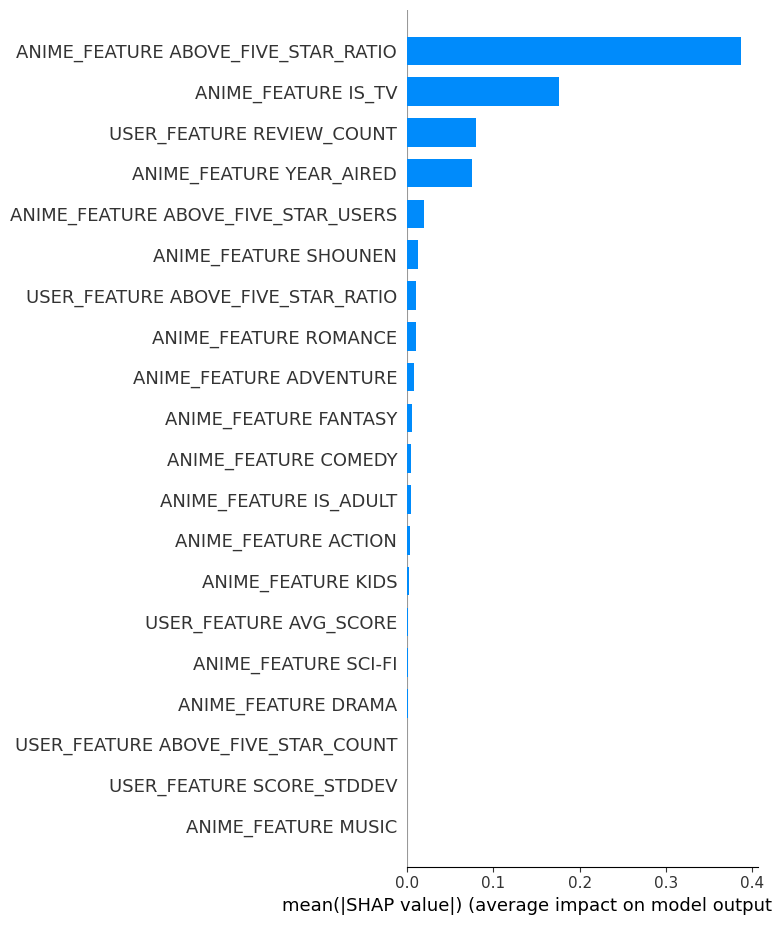

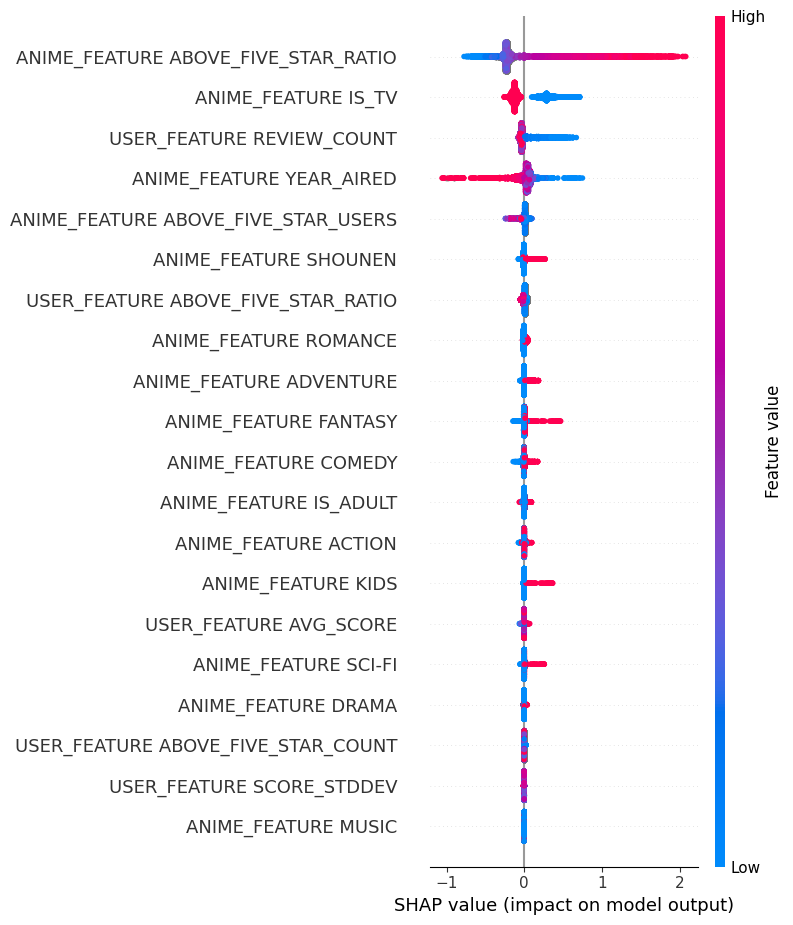

In [188]:
generate_shap_plots(model, xtrain, features, N=10000)

## Referencias

- https://everdark.github.io/k9/notebooks/ml/learning_to_rank/learning_to_rank.html
- https://github.com/Ransaka/LTR-with-LIghtGBM